# Revisited Importances

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
df = pd.read_csv('Data/sales_predictions_2023.csv')
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


# Set Visualization Style

In [4]:
## Customization Options
plt.style.use(('ggplot','tableau-colorblind10'))
sns.set_context(context='notebook', font_scale= 1.2)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.facecolor']='white'

# Clean Data

## Object Inconsistencies

In [5]:
object_type = df.dtypes[df.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

Item_Identifier ---
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content ---
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type ---
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier ---
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size ---
['Medium' nan 'High' 'Small']

Outlet_Location_Type ---
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type ---
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [6]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

# Preprocess

In [7]:
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [9]:
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [10]:
cat_select = make_column_selector(dtype_include='object')
cat_select(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [11]:
num_select = make_column_selector(dtype_include='number')
num_select(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [12]:
for col in cat_select(X_train):
    print(f'{col}:\n{df[col].unique()}\n')

Item_Fat_Content:
['Low Fat' 'Regular']

Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier:
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size:
['Medium' nan 'High' 'Small']

Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [13]:
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='median'))

In [14]:
preprocessor = make_column_transformer((cat_pipe, cat_select),
                                       (num_pipe, num_select),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15c5c9670>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15c5c9be0>)],
                  verbose_feature_names_out=False)

In [15]:
preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()
feature_names

/Users/huytran_1/anaconda3/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_MISSING',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Weight', 'Item_V

In [16]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names,
                          index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names,
                          index=X_test.index)

In [17]:
X_test_df.head(3)

,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,15.25,0.061531,132.2968,2007.0
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,17.85,0.044463,127.1020,1997.0
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.27,0.071078,114.2518,1997.0


In [18]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

# Custom Functions

In [19]:
def evaluate_regression(model, X_train=X_train_df,y_train=y_train, X_test=X_test_df, y_test=y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [20]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True, permutation=False, random_state=42,
                   X_train=X_train_df, y_train=y_train):
    
    r = permutation_importance(model, X_train, y_train, n_repeats =5, 
                                   random_state = random_state)
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
        
    if permutation==True:        
        importances = pd.Series(r['importances_mean'],index=X_train.columns,
                           name = 'permutation importance')
    
        # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [21]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [22]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        highlight_feats = importances.sort_values(ascending=True).tail(top_important).index
        colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}        
        colors = plot_vals.index.map(colors_dict)
        
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [23]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [24]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')    

    
    if annotate == True:
            for bar in ax.patches:
                ## calculate center of bar
                bar_ax = bar.get_y() + bar.get_height() / 2
                ## get the value to annotate
                val = bar.get_width()

                # handle negative values by setting them to position 0
                if val < 0:
                    val_pos = 0
                else:
                    val_pos = val        
        
                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                            ha=ha, va=va, size=size,
                            xytext=xytext, textcoords=textcoords)
    return ax


# Linear Regression Coefficient Visualization and Interpretation

In [25]:
linreg = LinearRegression()

linreg.fit(X_train_df, y_train)
evaluate_regression(linreg)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


## Extract Coefficients and Visualize

In [26]:
coeff = get_coeffs_linreg(linreg)
coeff

Outlet_Size_MISSING                 -698.975078
Outlet_Identifier_OUT019            -634.173663
Outlet_Identifier_OUT049            -382.139994
Item_Visibility                     -276.611557
Outlet_Size_Small                   -221.749671
Item_Type_Soft Drinks               -126.833270
Item_Type_Household                  -77.619396
Outlet_Location_Type_Tier 3          -63.250630
Item_Type_Dairy                      -57.820774
Item_Type_Health and Hygiene         -50.476996
Item_Type_Meat                       -24.889462
Item_Type_Snack Foods                -20.680311
Item_Type_Frozen Foods               -14.385193
Item_Type_Breads                     -13.069583
Outlet_Identifier_OUT035             -10.114103
Outlet_Establishment_Year             -9.719543
Item_Weight                            1.067856
Item_Type_Fruits and Vegetables        7.196229
Item_Type_Others                       8.629705
Item_Type_Canned                      13.622937
Item_MRP                              15

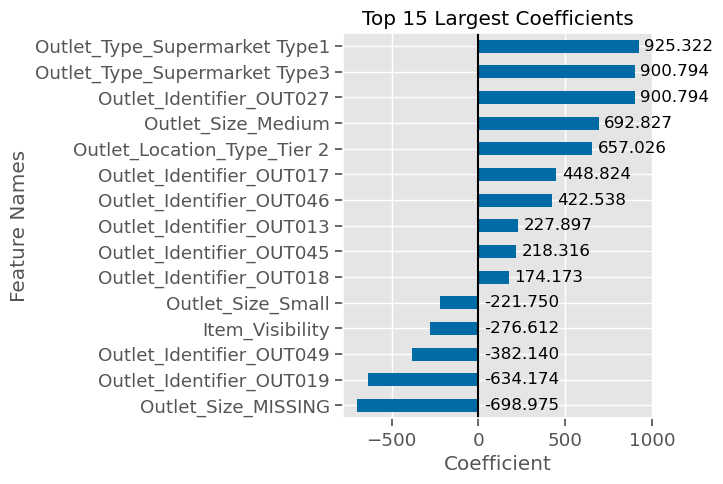

In [27]:
plot_coeffs(coeff, top_n=15, annotate=True);

Interpret Top 3 Most Impactful Features

- 'Outlet_Type_Supermarket Type1':
  - If the Outlet Type is Supermarket Type 1, increase in target value by 925.322

- 'Outlet_Identifier_OUT027':
  - If the Outlet Identifier is OUT027, increase in target value by 900.794

- 'Outlet_Type_Supermarket Type3':
  - If the Outlet Type is Supermarket Type 3, increase in target value by 900.794

- The most impactful features are object type



# RandomForest Default Feature Importance

In [28]:
cat_pipe_rf = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                            OneHotEncoder(drop='if_binary', sparse=False))

In [29]:
preprocessor_rf = make_column_transformer((cat_pipe_rf, cat_select), 
                                        (num_pipe, num_select),
                                        verbose_feature_names_out=False)
preprocessor_rf

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15c5c9670>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15c5c9be0>)],
                  verbose_feature_names_out=False)

In [30]:
preprocessor_rf.fit(X_train)

feature_names_rf = preprocessor_rf.get_feature_names_out()
feature_names_rf

/Users/huytran_1/anaconda3/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Gro

In [31]:
X_train_rf = pd.DataFrame(preprocessor_rf.transform(X_train), columns=feature_names_rf,
                          index=X_train.index)
X_test_rf = pd.DataFrame(preprocessor_rf.transform(X_test), columns=feature_names_rf,
                          index=X_test.index)
X_test_rf.head(3)

,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,15.25,0.061531,132.2968,2007.0
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,17.85,0.044463,127.1020,1997.0
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.27,0.071078,114.2518,1997.0


In [33]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

In [34]:
print(len(X_test_rf.columns))
len(X_test_df.columns)

42


37

In [36]:
rf = RandomForestRegressor(random_state=SEED)

rf.fit(X_train_rf, y_train)
evaluate_regression(rf, X_train=X_train_rf, X_test=X_test_rf)

Training Data:	R^2= 0.94	RMSE= 423.36
Test Data:	R^2= 0.56	RMSE= 1163.09


## Extract and Evaluate Feature Importance

In [37]:
importances_def = get_importances(rf, feature_names=None,name='Feature Importance',
                   sort=True, ascending=False, permutation=False, random_state=SEED,
                   X_train=X_train_rf, y_train=y_train)
importances_def

Item_MRP                           0.444427
Outlet_Type_Grocery Store          0.196758
Item_Visibility                    0.097388
Item_Weight                        0.053951
Outlet_Identifier_OUT027           0.030823
Outlet_Type_Supermarket Type3      0.028729
Outlet_Establishment_Year          0.025928
Item_Type_Fruits and Vegetables    0.008437
Item_Fat_Content_Regular           0.008232
Item_Type_Snack Foods              0.008151
Item_Type_Household                0.006289
Item_Type_Frozen Foods             0.005817
Item_Type_Dairy                    0.005602
Outlet_Identifier_OUT045           0.005010
Item_Type_Baking Goods             0.004547
Item_Type_Canned                   0.004411
Item_Type_Health and Hygiene       0.004290
Item_Type_Soft Drinks              0.004182
Outlet_Size_Small                  0.004126
Outlet_Identifier_OUT035           0.003831
Item_Type_Meat                     0.003608
Outlet_Identifier_OUT049           0.003293
Outlet_Location_Type_Tier 1     

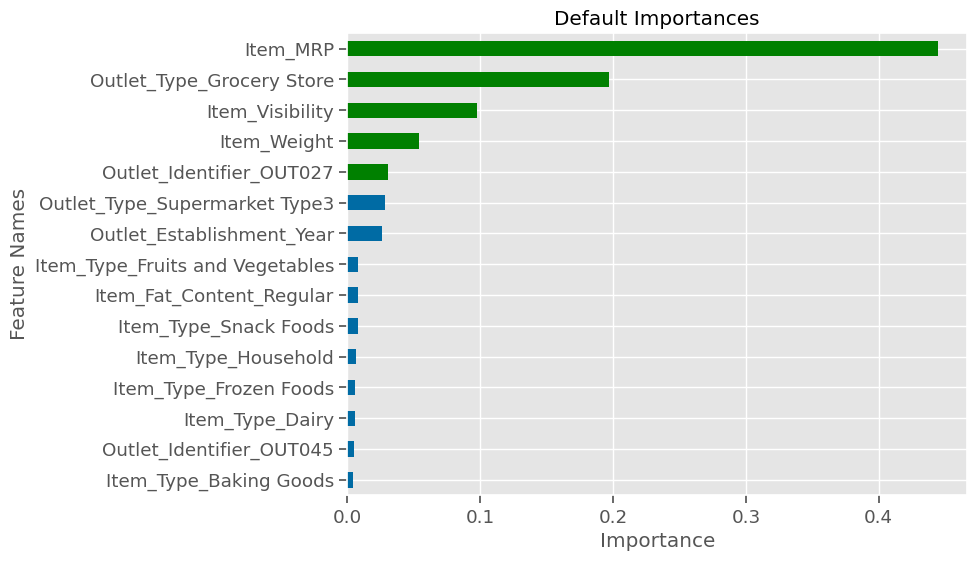

In [38]:
plot_importance_color(importances_def, top_n=15,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None)
plt.title('Default Importances');

    Top 5 most important
        'Item_MRP'
        'Outlet_Type_Grocery Store'
        'Item_Visibility'
        'Item_Weight'
        'Outlet_Identifier_OUT027'

# RandomForest Permutation Feature Importance

In [39]:
importances_perm = get_importances(rf, feature_names=None,name='Feature Importance',
                   sort=True, ascending=False, permutation=True, random_state=SEED,
                   X_train=X_train_rf, y_train=y_train)
importances_perm

Item_MRP                           1.103050
Outlet_Type_Grocery Store          0.455908
Item_Visibility                    0.179307
Item_Weight                        0.101938
Outlet_Identifier_OUT027           0.057571
Outlet_Establishment_Year          0.053202
Outlet_Type_Supermarket Type3      0.050659
Item_Fat_Content_Regular           0.015603
Item_Type_Fruits and Vegetables    0.014315
Item_Type_Snack Foods              0.014156
Item_Type_Household                0.013118
Outlet_Identifier_OUT045           0.011354
Outlet_Type_Supermarket Type1      0.009170
Outlet_Identifier_OUT035           0.008073
Outlet_Size_Small                  0.007668
Item_Type_Frozen Foods             0.007465
Outlet_Size_Medium                 0.007427
Outlet_Location_Type_Tier 3        0.006880
Item_Type_Dairy                    0.006798
Outlet_Location_Type_Tier 1        0.006147
Outlet_Identifier_OUT049           0.006069
Item_Type_Canned                   0.005662
Item_Type_Baking Goods          

In [40]:
color_top5 = get_color_dict(importances_def, color_rest='#006ba4' , color_top='green',
                    top_n=5)

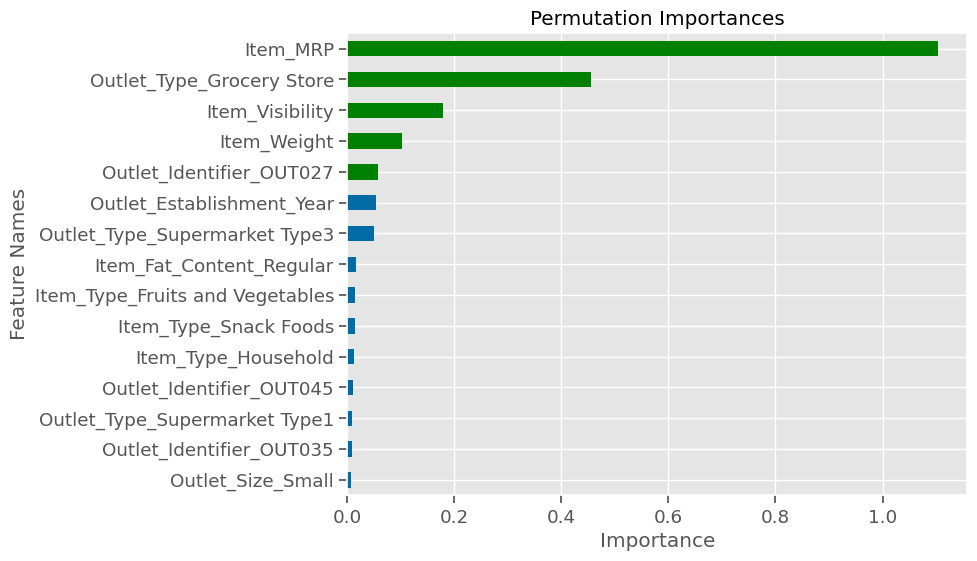

In [41]:
plot_importance_color(importances_perm, top_n=15,  figsize=(8,6), 
                          color_dict=color_top5, color_rest='#006ba4', color_top='green',
                          top_important=5)

plt.title('Permutation Importances');

    Top 5 Most Important:
        'Item_MRP'
        'Outlet_Type_Grocery Store'
        'Item_Visibility'
        'Item_Weight'
        'Outlet_Identifier_OUT027'

    Same features as Default Importance, but, in this case, the features are valued higher in importance compared to the Default



# Serializing Variables

In [42]:
export = {'X_train_df':X_train_df,
          'X_train_rf':X_train_rf,          
          'y_train': y_train,
          
          'X_test_df':X_test_df,
          'X_test_rf': X_test_rf,
          'y_test': y_test,
          
          'preprocessor':preprocessor,
          'preprocessor_rf':preprocessor_rf,
          'LinearRegression':linreg,
          'RandomForest':rf}
joblib.dump(export, 'Data/best_models.joblib')

['Data/best_models.joblib']

In [43]:
loaded = joblib.load('Data/best_models.joblib')
loaded.keys()

dict_keys(['X_train_df', 'X_train_rf', 'y_train', 'X_test_df', 'X_test_rf', 'y_test', 'preprocessor', 'preprocessor_rf', 'LinearRegression', 'RandomForest'])